# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)

<a name=imports></a>
## Imports

In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

<a name=data></a>
## Data

### Ingestion 

In [2]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
print("Parent Directory", parentDir)
# Save the path to all of the datasets
india_cases_path = os.path.join(parentDir, "../cleaned_datasets/india/daily_cases_india.csv")
india_vacc_path = os.path.join(parentDir, "../cleaned_datasets/india/daily_vacc_india.csv")
usa_cases_path = os.path.join(parentDir, "../cleaned_datasets/usa/daily_cases_usa.csv")
usa_vacc_path = os.path.join(parentDir, "../cleaned_datasets/usa/vacc_usa.csv")

# Quick check to make sure the path exists
print("Path:", india_cases_path)
print("Exists:", os.path.exists(india_cases_path))

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True


In [3]:
# Load the data as a pandas dataframe
india_cases_df = pd.read_csv(india_cases_path)
india_vacc_df =  pd.read_csv(india_vacc_path)

usa_cases_df = pd.read_csv(usa_cases_path)
usa_vacc_df = pd.read_csv(usa_vacc_path)

# Visualize the datasets
print('India Cases:\n',india_cases_df.head(),'\n')
print('India Vacc:\n',india_vacc_df.head(),'\n')

print('USA Cases:\n',usa_cases_df.head(),'\n')
print('USA Vacc:\n',usa_vacc_df.head(),'\n')

India Cases:
    Unnamed: 0        Date  Confirmed  Deaths  Recovered  Active
0           0  2020-01-30        1.0     0.0        0.0     0.0
1           1  2020-01-31        0.0     0.0        0.0     0.0
2           2  2020-02-01        0.0     0.0        0.0     0.0
3           3  2020-02-02        1.0     0.0        0.0     0.0
4           4  2020-02-03        1.0     0.0        0.0     0.0 

India Vacc:
    Updated On  Total_Doses  First_Dose  Second_Dose
0  2021-01-16          NaN         NaN          NaN
1  2021-01-17      20656.0     20656.0          0.0
2  2021-01-18      81690.0     81690.0          0.0
3  2021-01-19     192152.0    192152.0          0.0
4  2021-01-20     111510.0    111510.0          0.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-14    26713.0  2305.0     6484.0
1  2020-04-15    29380.0  2478.0     6093.0
2  2020-04-16    31542.0  4616.0     5234.0
3  2020-04-17    32022.0  3879.0     5904.0
4  2020-04-18    32502.0  1859.0    13591

### Pre-Processing

### Multivariate

In [4]:
india_cases_multi_df = india_cases_df[["Date","Confirmed","Deaths","Recovered","Active"]]

### Univariate 

In [5]:
# Select only the Confirmed column for univariate analysis
# Selecting from the first index because the 0th index is NaN
india_cases_df = india_cases_df[["Confirmed"]][1:]
usa_cases_df = usa_cases_df[["Confirmed"]][1:]

# Visualize the datasets
print('India Cases:\n',india_cases_df.head(),'\n')
print('USA Cases:\n',usa_cases_df.head(),'\n')

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    29380.0
2    31542.0
3    32022.0
4    32502.0
5    26588.0 



In [6]:
# Normalize the data
india_cases_mean = india_cases_df.mean()
india_cases_std = india_cases_df.std()

usa_cases_mean = usa_cases_df.mean()
usa_cases_std = usa_cases_df.std()


india_cases_normalized_df = (india_cases_df-india_cases_mean)/india_cases_std
usa_cases_normalized_df = (usa_cases_df-usa_cases_mean)/usa_cases_std

# Visualize the datasets
print('India Cases:\n',india_cases_normalized_df.head(),'\n')
print('USA Cases:\n',usa_cases_normalized_df.head(),'\n')

India Cases:
    Confirmed
1  -0.687995
2  -0.687995
3  -0.687983
4  -0.687983
5  -0.687995 

USA Cases:
    Confirmed
1  -0.759976
2  -0.727837
3  -0.720702
4  -0.713566
5  -0.801480 



In [7]:
# Create train test splits
india_cases_train, india_cases_test = train_test_split(india_cases_normalized_df, test_size=0.2, shuffle=False)
india_vacc_train, india_vacc_test = train_test_split(india_vacc_df, test_size=0.2, shuffle=False)

usa_cases_train, usa_cases_test = train_test_split(usa_cases_normalized_df, test_size=0.2, shuffle=False)
usa_vacc_train, usa_vacc_test = train_test_split(usa_vacc_df, test_size=0.2, shuffle=False)

# Visualize splits
print('India Cases:\n',india_cases_train,'\n')
print('USA Cases:\n',usa_cases_train,'\n')

India Cases:
      Confirmed
1    -0.687995
2    -0.687995
3    -0.687983
4    -0.687983
5    -0.687995
..         ...
492   0.750239
493   0.576535
494   0.398886
495   0.475509
496   0.486403

[496 rows x 1 columns] 

USA Cases:
      Confirmed
1    -0.759976
2    -0.727837
3    -0.720702
4    -0.713566
5    -0.801480
..         ...
432  -1.130479
433  -1.022988
434  -1.037824
435  -1.003589
436  -0.992157

[436 rows x 1 columns] 



In [8]:
# Convert to numpy array
india_cases_train, india_cases_test = india_cases_train.to_numpy().flatten(), india_cases_test.to_numpy()
usa_cases_train, usa_cases_test = usa_cases_train.to_numpy().flatten(), usa_cases_test.to_numpy()

# Visualize outputs
print('India Cases:\n',india_cases_train,'\n')
print('USA Cases:\n',usa_cases_train,'\n')

India Cases:
 [-6.87995117e-01 -6.87995117e-01 -6.87982552e-01 -6.87982552e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87969986e-01
 -6.87995117e-01 -6.87706113e-01 -6.87969986e-01 -6.87982552e-01
 -6.87957421e-01 -6.87932290e-01 -6.87944855e-01 -6.87831767e-01
 -6.87919725e-01 -6.87856898e-01 -6.87882028e-01 -6.87743809e-01
 -6.87856898e-01 -6.87919725e-01 -6.87706113e-01 -6.87819202e-01
 -6.87517632e-01 -6.87366848e-01 -6.86914494e-01 -6.87165802e-01
 -6.86700882e-01 -6.87530198e-01 -6.86474705e-01 -6.87115540e-01
 -6.85984655e-01 -6.86738578e-01 -6.87530198e-01 -6.85142775e-01
 -6.8616057

In [9]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
# choose a number of time steps
n_steps = 3
# split into samples
india_cases_train_X, india_cases_train_y = split_sequence(india_cases_train, n_steps)
india_cases_test_X, india_cases_test_y = split_sequence(india_cases_test, n_steps)
usa_cases_train_X, usa_cases_train_y = split_sequence(usa_cases_train, n_steps)
usa_cases_test_X, usa_cases_test_y = split_sequence(usa_cases_test, n_steps)

# summarize the data
for i in range(0,5):
    print(india_cases_train_X[i], india_cases_train_y[i])
print()
# summarize the data
for i in range(0,5):
    print(usa_cases_train_X[i], usa_cases_train_y[i])

[-0.68799512 -0.68799512 -0.68798255] -0.687982551549953
[-0.68799512 -0.68798255 -0.68798255] -0.6879951169346211
[-0.68798255 -0.68798255 -0.68799512] -0.6879951169346211
[-0.68798255 -0.68799512 -0.68799512] -0.6879951169346211
[-0.68799512 -0.68799512 -0.68799512] -0.6879951169346211

[-0.75997589 -0.72783707 -0.72070172] -0.7135663621434901
[-0.72783707 -0.72070172 -0.71356636] -0.8014798602697645
[-0.72070172 -0.71356636 -0.80147986] -0.8206709874393655
[-0.71356636 -0.80147986 -0.82067099] -0.7796129756326746
[-0.80147986 -0.82067099 -0.77961298] -0.7701734979001443


In [11]:
# Reshape the data into [samples, timesteps, features]
# univariate
n_features = 1

india_cases_train_X = india_cases_train_X.reshape((india_cases_train_X.shape[0], 
                                                   india_cases_train_X.shape[1], n_features))
india_cases_test_X = india_cases_test_X.reshape((india_cases_test_X.shape[0], 
                                                 india_cases_test_X.shape[1], n_features))

usa_cases_train_X = usa_cases_train_X.reshape((usa_cases_train_X.shape[0], 
                                                   usa_cases_train_X.shape[1], n_features))
usa_cases_test_X = usa_cases_test_X.reshape((usa_cases_test_X.shape[0], 
                                                   usa_cases_test_X.shape[1], n_features))

# Visualize outputs
print('India Cases:\n',india_cases_train_X,'\n')
print('USA Cases:\n',usa_cases_train_X,'\n')

India Cases:
 [[[-0.68799512]
  [-0.68799512]
  [-0.68798255]]

 [[-0.68799512]
  [-0.68798255]
  [-0.68798255]]

 [[-0.68798255]
  [-0.68798255]
  [-0.68799512]]

 ...

 [[ 0.82649813]
  [ 0.75023881]
  [ 0.57653493]]

 [[ 0.75023881]
  [ 0.57653493]
  [ 0.39888553]]

 [[ 0.57653493]
  [ 0.39888553]
  [ 0.47550924]]] 

USA Cases:
 [[[-0.75997589]
  [-0.72783707]
  [-0.72070172]]

 [[-0.72783707]
  [-0.72070172]
  [-0.71356636]]

 [[-0.72070172]
  [-0.71356636]
  [-0.80147986]]

 ...

 [[-1.07058673]
  [-1.13047911]
  [-1.02298798]]

 [[-1.13047911]
  [-1.02298798]
  [-1.03782357]]

 [[-1.02298798]
  [-1.03782357]
  [-1.00358874]]] 



<a name=model></a>
## Model 

In [12]:
# Imports for model components
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Univariate non-stacked -- Rolling

In [13]:
# Define the model
def build_univariate_non_stacked(optimizer="adam", lstm_nparams=100, n_steps=3, n_features=1):
    model_uni = Sequential()
    model_uni.add(LSTM(lstm_nparams, activation='relu', input_shape=(n_steps, n_features)))
    model_uni.add(Dense(1))
    model_uni.compile(optimizer=optimizer,loss='mae', metrics=["mae"])
    model_uni.summary()
    return model_uni

### Univariate non-stacked -- Long-Term

In [14]:
# Define the model
def build_univariate_non_stacked_long(optimizer="adam", lstm_nparams=100, n_steps=3, n_features=1):
    model_uni = Sequential()
    model_uni.add(LSTM(lstm_nparams, activation='relu', input_shape=(n_steps, n_features)))
    model_uni.add(Dense(10))
    model_uni.compile(optimizer=optimizer,loss='mae', metrics=["mae"])
    model_uni.summary()
    return model_uni

#### Grid Search

In [15]:
# Using KerasClassifier wrapper 
keras_estimator = KerasRegressor(build_fn=build_univariate_non_stacked, verbose=1)

In [16]:
# Defining parameters for the gridserach
param_grid = {
#     'epochs': [10,100,300,],
    'lstm_nparams':[15,50],
#     'n_steps': [3, 6, 15],
#     'optimizer': ['RMSprop','Adam','Adamax','sgd']
}

kfold_splits = 5

In [ ]:
# Defining GridSearch
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=-1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,
#                     scoring="neg_mean_absolute_error",
)

In [ ]:
# Fitting GridSearch
grid_result = grid.fit(india_cases_train_X, india_cases_train_y, )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Writing the gridsearch results to file
file1 = open("univariate_non_stacked_india.txt", "w")
file1.write("mean,stdev,pram")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    file1.write("%f,%f,%r" % (mean, stdev, param))
    file1.write("\n")
file1.close()

In [ ]:
sorted(grid_result.cv_results_.keys())

In [ ]:
grid_result.cv_results_['split2_train_score']

### Univariate stacked -- Rolling

In [17]:
# Define the model
def build_univariate_stacked(optimizer="adam",lstm_nparams_l1=100, lstm_nparams_l2=150, n_steps=3, n_features=1):
    model_uni_stacked = Sequential()
    model_uni_stacked.add(LSTM(lstm_nparams_l1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_uni_stacked.add(LSTM(lstm_nparams_l2, activation='relu'))
    model_uni_stacked.add(Dense(1))
    model_uni_stacked.compile(optimizer=optimizer,loss='mae')
    model_uni_stacked.summary()
    return model_uni_stacked

### Univariate stacked -- Long-Term

In [18]:
# Define the model
def build_univariate_stacked_long(optimizer="adam",lstm_nparams_l1=100, lstm_nparams_l2=150, n_steps=3, n_features=1):
    model_uni_stacked = Sequential()
    model_uni_stacked.add(LSTM(lstm_nparams_l1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_uni_stacked.add(LSTM(lstm_nparams_l2, activation='relu'))
    model_uni_stacked.add(Dense(10))
    model_uni_stacked.compile(optimizer=optimizer,loss='mae')
    model_uni_stacked.summary()
    return model_uni_stacked

#### Grid Search

In [ ]:
# Using KerasClassifier wrapper 
keras_estimator = KerasRegressor(build_fn=build_univariate_stacked, verbose=1)

In [ ]:
# Defining parameters for the gridserach
param_grid = {
    'epochs': [10,100,300,],
    'lstm_nparams_l1':[15,50,100,150],
    'lstm_nparams_l2':[15,50,100,150],
    'n_steps': [3, 6, 15],
#     'optimizer': ['RMSprop','Adam','Adamax','sgd']
}

kfold_splits = 5

In [ ]:
# Defining GridSearch
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=-1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,
                    scoring="neg_mean_absolute_error",
)

In [ ]:
# Fitting GridSearch
grid_result = grid.fit(india_cases_train_X, india_cases_train_y, )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Writing the gridsearch results to file
file1 = open("univariate_stacked_india.txt", "w")
file1.write("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
file1.write("\n")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    file1.write("%f (%f) with: %r" % (mean, stdev, param))
    file1.write("\n")
file1.close()

## Multivariate 

In [19]:
# Define the model
model_uni = Sequential()
model_uni.add(LSTM(150, activation='relu', input_shape=(n_steps, n_features)))
model_uni.add(Dense(1))
model_uni.compile(optimizer='adam',loss='mae')
model_uni.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


<a name=train></a>
## Train 

In [20]:
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
def tr

### Univariate non-stacked -- Rolling

In [83]:
# Fit the model
model_uni_non_stacked_india = build_univariate_non_stacked()
model_uni_non_stacked_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_india.save('univar_non_stack_rolling_india.h5')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 41,810
Trainable params: 41,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 1s 28ms/step - loss: 0.6689 - mae: 0.6689 - val_loss: 0.1987 - val_mae: 0.1987
Epoch 2/300
16/16 [==============================] - 0s 5ms/step - loss: 0.5964 - mae: 0.5964 - val_loss: 0.1539 - val_mae: 0.1539
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4135 - mae: 0.4135 - val_loss: 0.0981 - val_mae: 0.0981
Epoch 4/300
16/16 [==============================] - 0s 6ms/step - loss: 0.2050 - mae: 0.2050 - val_loss: 0.0841 - va

16/16 [==============================] - 0s 5ms/step - loss: 0.0678 - mae: 0.0678 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 120/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0723 - mae: 0.0723 - val_loss: 0.0655 - val_mae: 0.0655
Epoch 121/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0714 - mae: 0.0714 - val_loss: 0.0695 - val_mae: 0.0695
Epoch 122/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0709 - mae: 0.0709 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 123/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0682 - mae: 0.0682 - val_loss: 0.0651 - val_mae: 0.0651
Epoch 124/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0694 - mae: 0.0694 - val_loss: 0.0717 - val_mae: 0.0717
Epoch 125/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0701 - mae: 0.0701 - val_loss: 0.0660 - val_mae: 0.0660
Epoch 126/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0680 -

Epoch 181/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0642 - val_mae: 0.0642
Epoch 182/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0651 - mae: 0.0651 - val_loss: 0.0691 - val_mae: 0.0691
Epoch 183/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0665 - mae: 0.0665 - val_loss: 0.0640 - val_mae: 0.0640
Epoch 184/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0665 - mae: 0.0665 - val_loss: 0.0707 - val_mae: 0.0707
Epoch 185/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0679 - mae: 0.0679 - val_loss: 0.0637 - val_mae: 0.0637
Epoch 186/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0695 - mae: 0.0695 - val_loss: 0.0649 - val_mae: 0.0649
Epoch 187/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0701 - mae: 0.0701 - val_loss: 0.0649 - val_mae: 0.0649
Epoch 188/300
16/16 [==============================] - 0s 5ms/step - 

In [84]:
# Fit the model
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_usa.save('univar_non_stack_rolling_usa.h5')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 41,810
Trainable params: 41,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 1s 32ms/step - loss: 0.7451 - mae: 0.7451 - val_loss: 0.9488 - val_mae: 0.9488
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.6822 - mae: 0.6822 - val_loss: 0.9262 - val_mae: 0.9262
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 0.5778 - mae: 0.5778 - val_loss: 0.8806 - val_mae: 0.8806
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.3872 - mae: 0.3872 - val_loss: 0.8315 - va

14/14 [==============================] - 0s 6ms/step - loss: 0.1457 - mae: 0.1457 - val_loss: 0.8156 - val_mae: 0.8156
Epoch 120/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1456 - mae: 0.1456 - val_loss: 0.8124 - val_mae: 0.8124
Epoch 121/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1463 - mae: 0.1463 - val_loss: 0.8104 - val_mae: 0.8104
Epoch 122/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1485 - mae: 0.1485 - val_loss: 0.8128 - val_mae: 0.8128
Epoch 123/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1471 - mae: 0.1471 - val_loss: 0.8102 - val_mae: 0.8102
Epoch 124/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1491 - mae: 0.1491 - val_loss: 0.8086 - val_mae: 0.8086
Epoch 125/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1443 - mae: 0.1443 - val_loss: 0.8069 - val_mae: 0.8069
Epoch 126/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1448 -

Epoch 181/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1373 - mae: 0.1373 - val_loss: 0.8050 - val_mae: 0.8050
Epoch 182/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1382 - mae: 0.1382 - val_loss: 0.8058 - val_mae: 0.8058
Epoch 183/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1398 - mae: 0.1398 - val_loss: 0.8005 - val_mae: 0.8005
Epoch 184/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1438 - mae: 0.1438 - val_loss: 0.8052 - val_mae: 0.8052
Epoch 185/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1502 - mae: 0.1502 - val_loss: 0.7938 - val_mae: 0.7938
Epoch 186/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1435 - mae: 0.1435 - val_loss: 0.7860 - val_mae: 0.7860
Epoch 187/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1412 - mae: 0.1412 - val_loss: 0.7953 - val_mae: 0.7953
Epoch 188/300
14/14 [==============================] - 0s 6ms/step - 

### Univariate non-stacked -- Long-Term

In [85]:
# Fit the model
model_uni_non_stacked_long_india = build_univariate_non_stacked_long()
model_uni_non_stacked_long_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_long_india.save('univar_non_stacked_long_term_india.h5')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 41,810
Trainable params: 41,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 1s 28ms/step - loss: 0.6773 - mae: 0.6773 - val_loss: 0.2030 - val_mae: 0.2030
Epoch 2/300
16/16 [==============================] - 0s 6ms/step - loss: 0.6114 - mae: 0.6114 - val_loss: 0.1584 - val_mae: 0.1584
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4672 - mae: 0.4672 - val_loss: 0.0957 - val_mae: 0.0957
Epoch 4/300
16/16 [==============================] - 0s 6ms/step - loss: 0.2136 - mae: 0.2136 - val_loss: 0.0805 - va

16/16 [==============================] - 0s 5ms/step - loss: 0.0712 - mae: 0.0712 - val_loss: 0.0680 - val_mae: 0.0680
Epoch 120/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0686 - mae: 0.0686 - val_loss: 0.0672 - val_mae: 0.0672
Epoch 121/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0662 - mae: 0.0662 - val_loss: 0.0672 - val_mae: 0.0672
Epoch 122/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0684 - mae: 0.0684 - val_loss: 0.0660 - val_mae: 0.0660
Epoch 123/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0698 - mae: 0.0698 - val_loss: 0.0667 - val_mae: 0.0667
Epoch 124/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0719 - mae: 0.0719 - val_loss: 0.0718 - val_mae: 0.0718
Epoch 125/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0704 - mae: 0.0704 - val_loss: 0.0659 - val_mae: 0.0659
Epoch 126/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0685 -

Epoch 181/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 182/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0654 - mae: 0.0654 - val_loss: 0.0659 - val_mae: 0.0659
Epoch 183/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0674 - mae: 0.0674 - val_loss: 0.0674 - val_mae: 0.0674
Epoch 184/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0673 - val_mae: 0.0673
Epoch 185/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0687 - mae: 0.0687 - val_loss: 0.0641 - val_mae: 0.0641
Epoch 186/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0676 - mae: 0.0676 - val_loss: 0.0667 - val_mae: 0.0667
Epoch 187/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0652 - mae: 0.0652 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 188/300
16/16 [==============================] - 0s 5ms/step - 

In [86]:
# Fit the model
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_usa.save('univar_non_stack_rolling_usa.h5')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1010      
Total params: 41,810
Trainable params: 41,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 0s 23ms/step - loss: 0.1251 - mae: 0.1251 - val_loss: 0.7980 - val_mae: 0.7980
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.8031 - val_mae: 0.8031
Epoch 3/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1269 - mae: 0.1269 - val_loss: 0.8008 - val_mae: 0.8008
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1283 - mae: 0.1283 - val_loss: 0.8030 - va

Epoch 119/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1250 - mae: 0.1250 - val_loss: 0.8412 - val_mae: 0.8412
Epoch 120/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1214 - mae: 0.1214 - val_loss: 0.8273 - val_mae: 0.8273
Epoch 121/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1210 - mae: 0.1210 - val_loss: 0.8470 - val_mae: 0.8470
Epoch 122/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1183 - mae: 0.1183 - val_loss: 0.8594 - val_mae: 0.8594
Epoch 123/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1214 - mae: 0.1214 - val_loss: 0.8404 - val_mae: 0.8404
Epoch 124/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1197 - mae: 0.1197 - val_loss: 0.8516 - val_mae: 0.8516
Epoch 125/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1164 - mae: 0.1164 - val_loss: 0.8557 - val_mae: 0.8557
Epoch 126/300
14/14 [==============================] - 0s 6ms/step - 

Epoch 242/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1120 - mae: 0.1120 - val_loss: 0.9235 - val_mae: 0.9235
Epoch 243/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1100 - mae: 0.1100 - val_loss: 0.9547 - val_mae: 0.9547
Epoch 244/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1104 - mae: 0.1104 - val_loss: 0.9461 - val_mae: 0.9461
Epoch 245/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1111 - mae: 0.1111 - val_loss: 0.9481 - val_mae: 0.9481
Epoch 246/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1130 - mae: 0.1130 - val_loss: 0.9467 - val_mae: 0.9467
Epoch 247/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1108 - mae: 0.1108 - val_loss: 0.9400 - val_mae: 0.9400
Epoch 248/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1109 - mae: 0.1109 - val_loss: 0.9473 - val_mae: 0.9473
Epoch 249/300
14/14 [==============================] - 0s 5ms/step - 

### Univariate stacked -- Rolling

In [87]:
# Fit the model
model_uni_stacked_india = build_univariate_stacked()
model_uni_stacked_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_india.save('univar_stacked_rolling_india.h5')

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_24 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 2s 52ms/step - loss: 0.6412 - val_loss: 0.1539
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3482 - val_loss: 0.1294
Epoch 3/300
16/16 [==============================] - 0s 10ms/step - loss: 0.1309 - val_loss: 0.0822
Epoch 4/300
16/16 [==============================] - 0s 9ms/step - loss: 0.11

Epoch 72/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0735 - val_loss: 0.0707
Epoch 73/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0772 - val_loss: 0.0631
Epoch 74/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0788 - val_loss: 0.0686
Epoch 75/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0749 - val_loss: 0.0660
Epoch 76/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0692 - val_loss: 0.0642
Epoch 77/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0683 - val_loss: 0.0625
Epoch 78/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0733 - val_loss: 0.0688
Epoch 79/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0682 - val_loss: 0.0669
Epoch 80/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0689 - val_loss: 0.0635
Epoch 81/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0712 - val_loss: 0.06

Epoch 234/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0641 - val_loss: 0.0689
Epoch 235/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0632 - val_loss: 0.0597
Epoch 236/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0646 - val_loss: 0.0618
Epoch 237/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0667 - val_loss: 0.0638
Epoch 238/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0635 - val_loss: 0.0634
Epoch 239/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0679 - val_loss: 0.0616
Epoch 240/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0645 - val_loss: 0.0608
Epoch 241/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0636 - val_loss: 0.0600
Epoch 242/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0631 - val_loss: 0.0651
Epoch 243/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0653 - va

In [88]:
# Fit the model
model_uni_stacked_usa = build_univariate_stacked()
model_uni_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_usa.save('univar_stacked_rolling_usa.h5')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_26 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 2s 46ms/step - loss: 0.7173 - val_loss: 0.9302
Epoch 2/300
14/14 [==============================] - 0s 9ms/step - loss: 0.5607 - val_loss: 0.8503
Epoch 3/300
14/14 [==============================] - 0s 9ms/step - loss: 0.2782 - val_loss: 0.8897
Epoch 4/300
14/14 [==============================] - 0s 10ms/step - loss: 0.219

14/14 [==============================] - 0s 9ms/step - loss: 0.1480 - val_loss: 0.7751
Epoch 73/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1491 - val_loss: 0.7684
Epoch 74/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1523 - val_loss: 0.7693
Epoch 75/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1535 - val_loss: 0.7719
Epoch 76/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1574 - val_loss: 0.7679
Epoch 77/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1463 - val_loss: 0.7676
Epoch 78/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1483 - val_loss: 0.7670
Epoch 79/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1456 - val_loss: 0.7697
Epoch 80/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1469 - val_loss: 0.7647
Epoch 81/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1447 - val_loss: 0.7632
Epoch 82/300

Epoch 234/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1198 - val_loss: 0.8051
Epoch 235/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1196 - val_loss: 0.8221
Epoch 236/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1196 - val_loss: 0.7869
Epoch 237/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1229 - val_loss: 0.8071
Epoch 238/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1210 - val_loss: 0.8106
Epoch 239/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1258 - val_loss: 0.8000
Epoch 240/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1207 - val_loss: 0.7980
Epoch 241/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1198 - val_loss: 0.8103
Epoch 242/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1203 - val_loss: 0.8070
Epoch 243/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1243 -

### Univariate stacked -- Long-Term

In [89]:
# Fit the model
model_uni_stacked_long_india = build_univariate_stacked_long()
model_uni_stacked_long_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_long_india.save('univar_stacked_long_term.h5')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_28 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1510      
Total params: 192,910
Trainable params: 192,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 2s 43ms/step - loss: 0.6775 - val_loss: 0.1893
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.5489 - val_loss: 0.0805
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.2059 - val_loss: 0.0854
Epoch 4/300
16/16 [==============================] - 0s 9ms/step - loss: 0.131

16/16 [==============================] - 0s 9ms/step - loss: 0.0691 - val_loss: 0.0657
Epoch 73/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0712 - val_loss: 0.0629
Epoch 74/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0745 - val_loss: 0.0627
Epoch 75/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0814 - val_loss: 0.0649
Epoch 76/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0696 - val_loss: 0.0646
Epoch 77/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0850 - val_loss: 0.0702
Epoch 78/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0812 - val_loss: 0.0733
Epoch 79/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0832 - val_loss: 0.0653
Epoch 80/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0719 - val_loss: 0.0675
Epoch 81/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0717 - val_loss: 0.0678
Epoch 82/30

16/16 [==============================] - 0s 8ms/step - loss: 0.0648 - val_loss: 0.0643
Epoch 235/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0629 - val_loss: 0.0651
Epoch 236/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0628 - val_loss: 0.0686
Epoch 237/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0630 - val_loss: 0.0667
Epoch 238/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0632 - val_loss: 0.0708
Epoch 239/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0694 - val_loss: 0.0660
Epoch 240/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0622
Epoch 241/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0657 - val_loss: 0.0652
Epoch 242/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0645 - val_loss: 0.0661
Epoch 243/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0656 - val_loss: 0.0645

In [90]:
# Fit the model
model_uni_stacked_long_usa = build_univariate_stacked()
model_uni_stacked_long_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_long_usa.save('univar_stacked_long_term_usa.h5')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_30 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 2s 46ms/step - loss: 0.6857 - val_loss: 0.9161
Epoch 2/300
14/14 [==============================] - 0s 9ms/step - loss: 0.4468 - val_loss: 0.8429
Epoch 3/300
14/14 [==============================] - 0s 9ms/step - loss: 0.2322 - val_loss: 0.8051
Epoch 4/300
14/14 [==============================] - 0s 10ms/step - loss: 0.202

14/14 [==============================] - 0s 10ms/step - loss: 0.1470 - val_loss: 0.7597
Epoch 73/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1470 - val_loss: 0.7612
Epoch 74/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1448 - val_loss: 0.7609
Epoch 75/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1460 - val_loss: 0.7627
Epoch 76/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1434 - val_loss: 0.7608
Epoch 77/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1448 - val_loss: 0.7678
Epoch 78/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1476 - val_loss: 0.7729
Epoch 79/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1485 - val_loss: 0.7639
Epoch 80/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1421 - val_loss: 0.7636
Epoch 81/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1439 - val_loss: 0.7581
Epoch 82/30

14/14 [==============================] - 0s 10ms/step - loss: 0.1198 - val_loss: 0.8199
Epoch 235/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1230 - val_loss: 0.8179
Epoch 236/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1206 - val_loss: 0.8190
Epoch 237/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1177 - val_loss: 0.8243
Epoch 238/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1213 - val_loss: 0.8339
Epoch 239/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1276 - val_loss: 0.8229
Epoch 240/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1207 - val_loss: 0.8214
Epoch 241/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1214 - val_loss: 0.8181
Epoch 242/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1198 - val_loss: 0.8259
Epoch 243/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1202 - val_loss: 0.8216
Epo

<a name=predict></a>
## Predict

In [70]:
india_cases_test_X.shape

(122, 3, 1)

In [71]:
india_cases_test.shape

(125, 1)

In [ ]:
def make_predictions(test_X, model):
    x_input = np.array(test_X)
    y_hat = model.predict(x_input)

### Univariate Non Stacked -- Rolling

In [62]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_india = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_india.shape)
yhat_uni_non_stacked_india = model_uni_non_stacked.predict(x_input)
print(yhat_uni_non_stacked_india.shape)

(122, 3, 1)
(122, 10)


In [ ]:
# Predictions for usa cases on test dataset
x_input_uni_non_stacked_usa = np.array(usa_cases_test_X)
print(x_input_uni_non_stacked_usa.shape)
yhat_uni_non_stacked_usa = model_uni_non_stacked_usa.predict(x_input)
print(yhat_uni_non_stacked_usa.shape)

### Univariate Non Stacked -- Long-Term

In [63]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_long_india = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_long_india.shape)
yhat_uni_non_stacked_long_india = model_uni_non_stacked_long_india.predict(x_input)
print(yhat_uni_non_stacked_long_india.shape)

(122, 3, 1)
(122, 10)


In [63]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_long = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_long.shape)
yhat_uni_non_stacked_long = model_uni_non_stacked_long.predict(x_input)
print(yhat_uni_non_stacked_long.shape)

(122, 3, 1)
(122, 10)


### Univariate Stacked -- Rolling

In [64]:
# Predictions for india cases on test dataset
x_input_uni_stacked = np.array(india_cases_test_X)
print(x_input_uni_stacked.shape)
yhat_uni_stacked = model_uni_stacked.predict(x_input)
print(yhat_uni_stacked.shape)

(122, 3, 1)
(122, 1)


### Univariate Stacked -- Long-Term

In [65]:
# Predictions for india cases on test dataset
x_input_uni_stacked_long = np.array(india_cases_test_X)
print(x_input_uni_stacked_long.shape)
yhat_uni_stacked_long = model_uni_stacked_long.predict(x_input)
print(yhat_uni_stacked_long.shape)

(122, 3, 1)
(122, 10)


## Evaluate

### Univariate Non Stacked -- Rolling

In [72]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_non_stacked_india).numpy()

37.4175

In [73]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_non_stacked_india).numpy()

0.061723262

### Univariate Non Stacked -- Long-Term

In [74]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_non_stacked_long).numpy()

42.458015

In [75]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_non_stacked_long).numpy()

0.06621277

### Univariate Stacked -- Rolling

In [76]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_stacked).numpy()

36.859512

In [77]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_stacked).numpy()

0.060793385

### Univariate Stacked -- Long-Term

In [78]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_stacked_long).numpy()

40.21965

In [79]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_stacked_long).numpy()

0.061704535

## Plots

In [53]:
# Reversing Z-score normalization

casted_mean = india_cases_mean.to_numpy()
casted_std = india_cases_std.to_numpy()

india_cases_test_scaled = (india_cases_test*india_cases_std[0])+india_cases_mean[0]
yhat_uni_non_stacked = (india_cases_std[0]*yhat_uni_non_stacked)+india_cases_mean[0]
yhat_uni_non_stacked_long = (india_cases_std[0]*yhat_uni_non_stacked_long)+india_cases_mean[0]
yhat_uni_stacked = (india_cases_std[0]*yhat_uni_stacked)+india_cases_mean[0]
yhat_uni_stacked_long = (india_cases_std[0]*yhat_uni_stacked_long)+india_cases_mean[0]

print(yhat_uni_non_stacked.size)
print(yhat_scaled.size)

125
1220


In [54]:
def plot_fore_test(test, fore, title):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)

    ax.plot(test, color='blue', label='Test')
    ax.plot(fore, color='red', label='Forecast')
    ax.legend(loc='best')
    plt.title(title)
    plt.show()

### Univariate Non Stacked -- Rolling

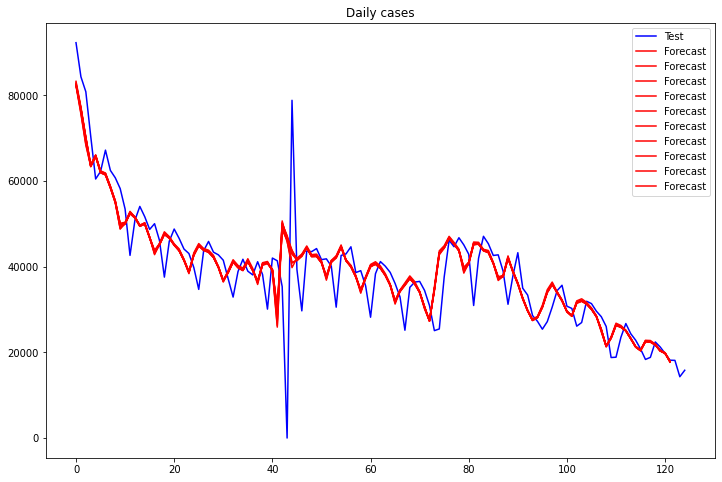

In [56]:
plot_fore_test(india_cases_test_scaled, yhat_uni_non_stacked, title='Daily cases')

### Univariate Non Stacked -- Long-Term

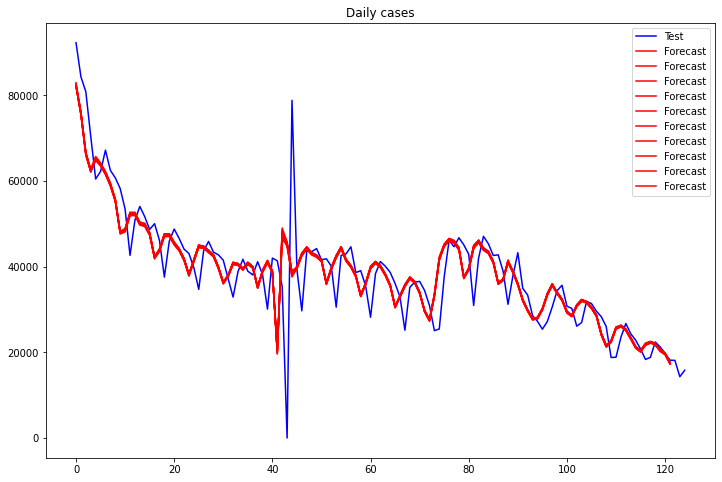

In [57]:
plot_fore_test(india_cases_test_scaled, yhat_uni_non_stacked_long, title='Daily cases')

### Univariate Stacked -- Rolling

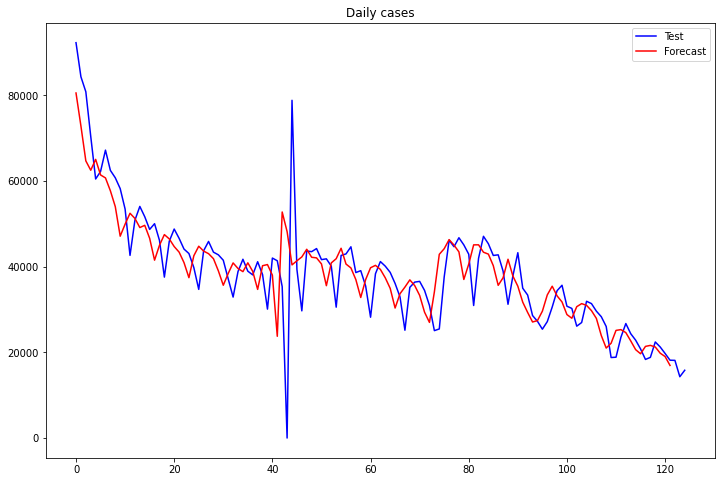

In [60]:
plot_fore_test(india_cases_test_scaled, yhat_uni_stacked, title='Daily cases')

### Univariate Stacked -- Long-Term

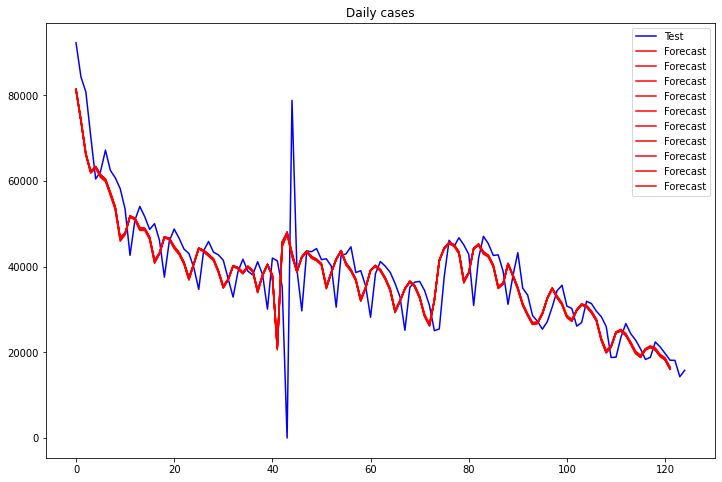

In [61]:
plot_fore_test(india_cases_test_scaled, yhat_uni_stacked_long, title='Daily cases')